# 머신 러닝 교과서 2판

# 13장 - 텐서플로를 사용한 신경망 훈련 (2/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part2.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 텐서플로로 신경망 모델 만들기
  - 텐서플로 케라스 API (tf.keras)
  - 선형 회귀 모델 만들기
  - `.compile()`과 `.fit()` 메서드를 사용한 모델 훈련
  - 붓꽃 데이터셋을 분류하는 다층 퍼셉트론 만들기
  - 테스트 데이터셋에서 훈련된 모델 평가하기
  - 훈련된 모델 저장하고 복원하기
- 다층 신경망의 활성화 함수 선택
  - 로지스틱 함수 요약
  - 소프트맥스 함수를 사용한 다중 클래스 확률 예측
  - 하이퍼볼릭 탄젠트로 출력 범위 넓히기
  - 렐루 활성화 함수

## 텐서플로로 신경망 모델 만들기

### 텐서플로 케라스 API (tf.keras)

### 선형 회귀 모델 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

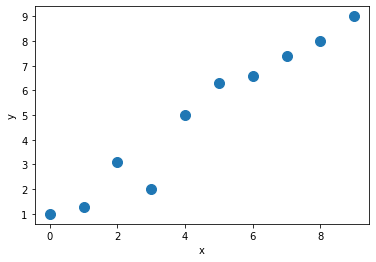

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('images/13_5.png', dpi=300)
plt.show()

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [4]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [5]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [6]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [7]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('에포크 {:3d} 스텝 {:4d} 손실 {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

에포크   0 스텝    0 손실 43.5600
에포크  10 스텝  100 손실 0.7530
에포크  20 스텝  200 손실 20.1759
에포크  30 스텝  300 손실 23.3976
에포크  40 스텝  400 손실 6.3481
에포크  50 스텝  500 손실 4.6356
에포크  60 스텝  600 손실 0.2411
에포크  70 스텝  700 손실 0.2036
에포크  80 스텝  800 손실 3.8177
에포크  90 스텝  900 손실 0.9416
에포크 100 스텝 1000 손실 0.7035
에포크 110 스텝 1100 손실 0.0348
에포크 120 스텝 1200 손실 0.5404
에포크 130 스텝 1300 손실 0.1170
에포크 140 스텝 1400 손실 0.1195
에포크 150 스텝 1500 손실 0.0944
에포크 160 스텝 1600 손실 0.4670
에포크 170 스텝 1700 손실 2.0695
에포크 180 스텝 1800 손실 0.0020
에포크 190 스텝 1900 손실 0.3612


최종 파라미터: 2.6576622 4.8798566


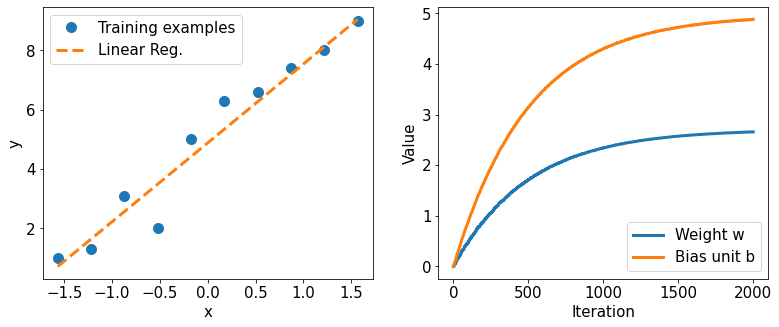

In [8]:
print('최종 파라미터:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('images/13_6.png', dpi=300)
plt.show()

### `.compile()`과 `.fit()` 메서드를 사용한 모델 훈련

In [9]:
tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [10]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)


Epoch 1/200
10/10 [==============================] - 0s 753us/step - loss: 24.1936 - mae: 4.2272 - mse: 24.1936
Epoch 2/200
10/10 [==============================] - 0s 586us/step - loss: 23.8432 - mae: 4.2359 - mse: 23.8432
Epoch 3/200
10/10 [==============================] - 0s 658us/step - loss: 14.6246 - mae: 3.3842 - mse: 14.6246
Epoch 4/200
10/10 [==============================] - 0s 486us/step - loss: 8.2254 - mae: 2.5414 - mse: 8.2254
Epoch 5/200
10/10 [==============================] - 0s 505us/step - loss: 5.2206 - mae: 1.9139 - mse: 5.2206
Epoch 6/200
10/10 [==============================] - 0s 655us/step - loss: 3.3134 - mae: 1.5093 - mse: 3.3134
Epoch 7/200
10/10 [==============================] - 0s 492us/step - loss: 2.9805 - mae: 1.5563 - mse: 2.9805
Epoch 8/200
10/10 [==============================] - 0s 493us/step - loss: 2.1105 - mae: 1.2776 - mse: 2.1105
Epoch 9/200
10/10 [==============================] - 0s 633us/step - loss: 1.8970 - mae: 1.2999 - mse: 1.8970
Epoc

10/10 [==============================] - 0s 449us/step - loss: 0.1988 - mae: 0.3741 - mse: 0.1988
Epoch 148/200
10/10 [==============================] - 0s 505us/step - loss: 0.2731 - mae: 0.3760 - mse: 0.2731
Epoch 149/200
10/10 [==============================] - 0s 460us/step - loss: 0.1738 - mae: 0.3364 - mse: 0.1738
Epoch 150/200
10/10 [==============================] - 0s 479us/step - loss: 0.5995 - mae: 0.5936 - mse: 0.5995
Epoch 151/200
10/10 [==============================] - 0s 513us/step - loss: 0.3315 - mae: 0.4207 - mse: 0.3315
Epoch 152/200
10/10 [==============================] - 0s 451us/step - loss: 0.2122 - mae: 0.3562 - mse: 0.2122
Epoch 153/200
10/10 [==============================] - 0s 530us/step - loss: 0.5835 - mae: 0.5471 - mse: 0.5835
Epoch 154/200
10/10 [==============================] - 0s 458us/step - loss: 0.3150 - mae: 0.4616 - mse: 0.3150
Epoch 155/200
10/10 [==============================] - 0s 480us/step - loss: 0.8182 - mae: 0.7285 - mse: 0.8182
Epoch 

2.7067394 4.9657216


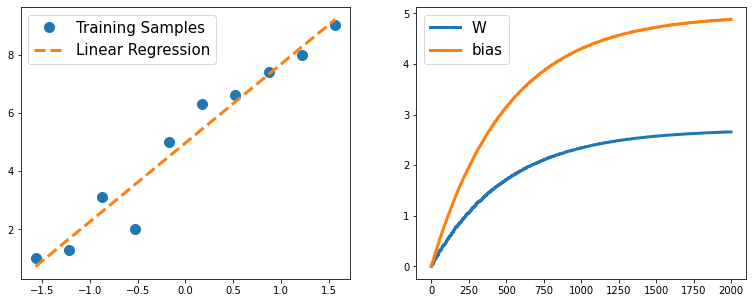

In [11]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

## 붓꽃 데이터셋을 분류하는 다층 퍼셉트로 만들기

In [12]:
import tensorflow_datasets as tfds



iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archiv

In [13]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [14]:
## 샘플 개수 확인

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


In [15]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [16]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [17]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [18]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

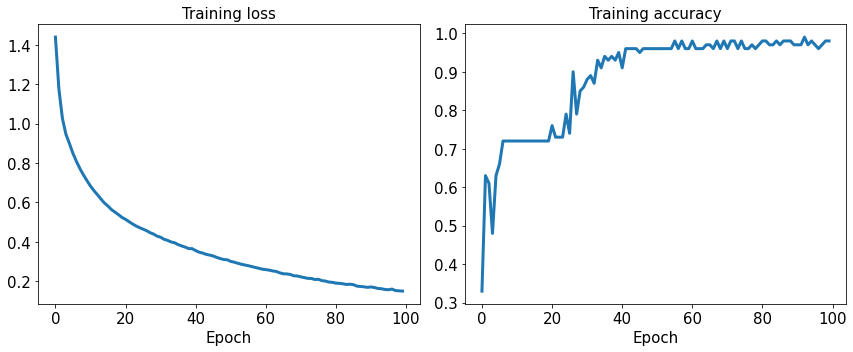

In [19]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('images/13_7.png', dpi=300)
plt.show()

### 테스트 데이터셋에서 훈련된 모델 평가하기

In [20]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


### 훈련된 모델 저장하고 복원하기

In [21]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [22]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [23]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


In [24]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('훈련 데이터셋: ',len(labels_train), '테스트 데이터셋: ', len(labels_test))

훈련 데이터셋:  100 테스트 데이터셋:  50


In [25]:
iris_model_new.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 4], "dtype": "float32", "sparse": false, "ragged": false, "name": "fc1_input"}}, {"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "batch_input_shape": [null, 4], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regu

케라스 모델의 `fit()` 메서드는 `callbacks` 매개변수를 사용하여 훈련 과정을 제어할 수 있습니다. 이 매개변수는 `keras.callbacks` 아래에 있는 콜백 객체의 리스트를 입력받습니다. 예를 들어 모델을 훈련하는 동안 `ModelCheckpoint` 콜백을 사용하여 최고의 성능을 내는 가중치를 저장할 수 있습니다. `ModelCheckpoint` 콜백은 더 이상 성능이 개선되지 않을 때 훈련을 멈추게 하는 `EarlyStopping` 콜백과 함께 사용하는 경우가 많습니다. `EarlyStopping` 콜백 클래스는 기본적으로 검증 손실을 모니터링합니다. `patience` 매개변수가 지정한 에포크 횟수 동안 모니터링 지표가 개선되지 않으면 훈련을 중지합니다.

다음 코드는 `ModelCheckpoint` 콜백을 사용하는 예입니다. 검증 손실을 모니터링하면서(`monitor='val_loss'`) 3번 에포크 동안 검증 손실이 감소하지 않으면 훈련을 중지하고 최상의 모델 가중치로 복원합니다(`restore_best_weights=True`).

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callback_list = [ModelCheckpoint(filepath='iris-earlystopping.h5', 
                                 monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True)]

그 다음 `Sequential` 클래스를 사용하지 않고 `iris_model` 모델의 구조를 추출하여 새로운 모델을 만들어 보겠습니다. `model_from_json()` 함수를 사용하여 `to_json()` 메서드로 만든 구조로 새로운 모델을 만들 수 있습니다. `compile()` 메서드에 지정한 것은 이전과 동일합니다. `fit()` 메서드에는 `validation_data` 매개변수에 검증 데이터셋으로 사용할 데이터를 전달합니다. 여기에서는 간단한 예를 보는 것이 목적이므로 별도의 검증 데이터셋을 만들지 않고 대신 `ds_test` 데이터셋을 사용하겠습니다. `callbacks` 매개변수에 앞에서 만든 콜백 리스트를 전달합니다. 에포크를 크게 설정해도(`epochs=500`) 조기 종료를 사용하기 때문에 종료 조건이 만족되면 훈련이 중간에 중단될 것입니다.

In [27]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)

훈련이 끝난 후 손실과 정확도 그래프를 그려 보죠. 이번에는 검증 손실과 검증 정확도도 함께 그려 보겠습니다.

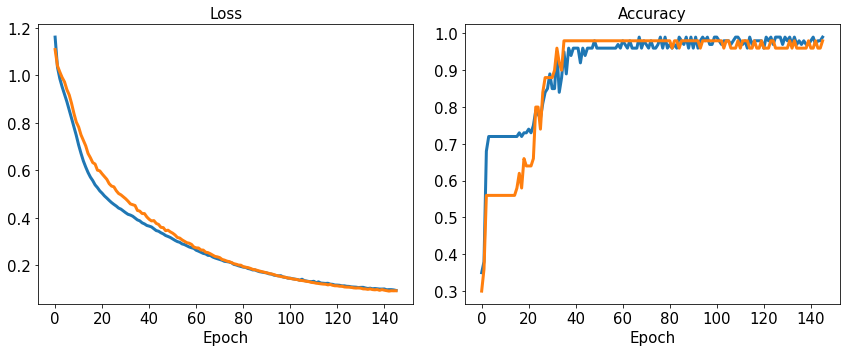

In [28]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('images/13_earlystopping.png', dpi=300)
plt.show()

500번의 에포크를 지정했지만 훈련은 200번째 에포크 근처에서 중지되었습니다. 몇 번째 에포크에서 훈련이 중지되었는지 확인하려면 `EarlyStopping` 객체의 `stopped_epoch` 속성을 출력하면 됩니다.

In [29]:
callback_list[1].stopped_epoch

145

텐서플로의 놀라운 기능 중 하나는 텐서보드(TensorBoard)입니다. 텐서보드는 모델의 학습 과정뿐만 아니라 계산 그래프도 시각화할 수 있는 모듈입니다. 앞서 케라스 API로 만들었던 신경망을 시각화해 보죠. 먼저 텐서보드에 필요한 로그를 위해 콜백 함수를 정의합니다.

In [30]:
from tensorflow.keras.callbacks import TensorBoard

callback_list = [ModelCheckpoint(filepath='iris-earlystopping.h5', 
                                 monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True),
                 TensorBoard()]

텐서보드를 위한 로그가 기록되는 기본 위치는 `logs` 입니다. 저장 위치를 바꾸려면 `TensorBoard` 콜백 클래스의 `log_dir` 매개변수에 지정할 수 있습니다. 그다음 모델 정의, 컴파일, 훈련은 이전과 동일합니다.

In [31]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)

TensorBoard를 실행하고 브라우저로 접속하려면 터미널에서 다음 명령을 실행하세요.

```
tensorboard --logdir=logs/
```

이 명령을 실행하면 URL 주소가 출력됩니다. http://localhost:6006/ 와 같은 링크를 복사하여 웹 브라우저 주소 표시줄에 붙여 넣어 텐서보드에 접속할 수 있습니다. 텐서플로 2.0부터는 주피터 노트북에 텐서보드를 포함시킬 수 있습니다. 주피터 노트북에서 다음 명령을 실행하세요.

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 24494), started 1:00:11 ago. (Use '!kill 24494' to kill it.)

텐서보드에 대한 더 자세한 내용은 공식 문서(https://www.tensorflow.org/tensorboard)를 참고하세요.

## 다층 신경망의 활성화 함수 선택

### 로지스틱 함수 요약

In [33]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 

P(y=1|x) = 0.888


In [34]:
# W : (n_output_units, n_hidden_units+1) 크기의 배열
# 첫 번째 열은 절편 유닛입니다

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : (n_hidden_units + 1, n_samples) 크기의 배열
# 이 배열의 첫 번째 열은 1입니다

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('최종 입력: \n', Z)

print('유닛 출력:\n', y_probas) 

최종 입력: 
 [1.78 0.76 1.65]
유닛 출력:
 [0.85569687 0.68135373 0.83889105]


In [35]:
y_class = np.argmax(Z, axis=0)
print('예측 클래스 레이블: %d' % y_class) 

예측 클래스 레이블: 0


### 소프트맥스 함수를 사용한 다중 클래스 확률 예측

In [36]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('확률:\n', y_probas)

np.sum(y_probas)

확률:
 [0.44668973 0.16107406 0.39223621]


1.0

In [37]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

### 하이퍼볼릭 탄젠트로 출력 범위 넓히기

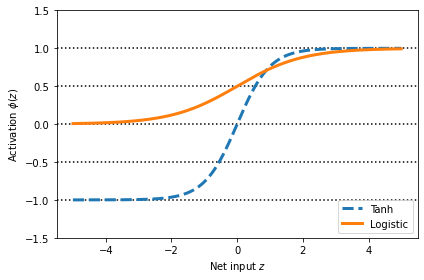

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/13_8.png', dpi=300)
plt.show()

In [39]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [40]:
import tensorflow as tf

tf.keras.activations.tanh(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [41]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [42]:
tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

### 렐루 활성화 함수

In [43]:
import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

## 요약

# 부록

## 데이터셋 분할: 훈련/테스트 샘플을 섞으면 위험합니다

In [44]:
## 올바른 방법
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=False)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 5, 9, 10, 11, 12, 14} {4, 6, 7, 8, 13}


In [45]:
## 잘못된 방법:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=True)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14}


### `tfds.Split`를 사용하여 데이터셋 나누기

In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

ds_train_orig = tfds.load('iris', split='train[:67%]')
ds_test = tfds.load('iris', split='train[67%:]')

print(next(iter(ds_train_orig)))
print()
print(next(iter(ds_test)))


ds_train_orig = ds_train_orig.shuffle(100, reshuffle_each_iteration=True)
ds_test  = ds_test.shuffle(50, reshuffle_each_iteration=False)

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

print(next(iter(ds_train_orig)))


for j in range(5):
    labels_train = []
    for i,item in enumerate(ds_train_orig):
        labels_train.append(item[1].numpy())

    labels_test = []
    for i,item in enumerate(ds_test):
        labels_test.append(item[1].numpy())
    print('훈련 데이터셋: ',len(labels_train), '테스트 데이터셋: ', len(labels_test))

    labels_test = np.array(labels_test)

    print(np.sum(labels_test == 0), np.sum(labels_test == 1), np.sum(labels_test == 2))

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.1, 3.4, 1.5, 0.2], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.3, 3.4, 5.6, 2.4], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}
(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.4, 3. , 4.5, 1.5], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
훈련 데이터셋:  100 테스트 데이터셋:  50
15 16 19
훈련 데이터셋:  100 테스트 데이터셋:  50
15 16 19
훈련 데이터셋:  100 테스트 데이터셋:  50
15 16 19
훈련 데이터셋:  100 테스트 데이터셋:  50
15 16 19
훈련 데이터셋:  100 테스트 데이터셋:  50
15 16 19
